In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
import uproot
from collections import defaultdict
sys.path.append("..")

from plotting import histos
from processing import kinematics
from ttbar_reconstruction import four_momentum

## Reconstructions

In [2]:
base_path = "../reconstructions/SM_spin-ON_10k"
reco_names = [
    "p_top", "p_l_t", "p_b_t", "p_nu_t",
    "p_tbar", "p_l_tbar", "p_b_tbar", "p_nu_tbar", "idx"
]
batches = {name: [] for name in reco_names}

In [3]:
for batch_idx in range(10):
    for name in reco_names:
        batches[name].append(np.load(os.path.join(base_path, f"{name}_batch_{batch_idx}.npy")))

arrays = {name: np.concatenate(batches, axis=0) for name, batches in batches.items()}

## Events

In [4]:
events_path = "../mg5_data/SM-process_spin-ON_10k/Events/run_01_decayed_1/tag_1_delphes_events.root"
events = uproot.open(events_path)["Delphes"]
idx_mask = arrays["idx"].reshape(-1)

In [5]:
nu_e_t_mask = (
    (events["Particle.PID"].array() == 12) * (events["Particle.Status"].array() == 1)
)
nu_mu_t_mask = (
    (events["Particle.PID"].array() == 14) * (events["Particle.Status"].array() == 1)
)
nu_e_tbar_mask = (
    (events["Particle.PID"].array() == -12) * (events["Particle.Status"].array() == 1)
)
nu_mu_tbar_mask = (
    (events["Particle.PID"].array() == -14) * (events["Particle.Status"].array() == 1)
)

### Leptons

In [6]:
m_e = 0.000510998902
m_mu = 0.10565838

e_t_mask = (
    (events["Particle.PID"].array() == -11) * (events["Particle.Status"].array() == 1)
)
mu_t_mask = (
    (events["Particle.PID"].array() == -13) * (events["Particle.Status"].array() == 1)
)
e_tbar_mask = (
    (events["Particle.PID"].array() == 11) * (events["Particle.Status"].array() == 1)
)
mu_tbar_mask = (
    (events["Particle.PID"].array() == 13) * (events["Particle.Status"].array() == 1)
)

In [7]:
def get_leptons_pre(events, e_mask, mu_mask):
    coords = ["PT", "Eta", "Phi"]
    e_kinematics = {
        coord: events[f"Particle.{coord}"].array()[e_mask][idx_mask]
        for coord in coords
    }
    mu_kinematics = {
        coord: events[f"Particle.{coord}"].array()[mu_mask][idx_mask]
        for coord in coords
    }

    l_pre = []
    for event_idx in range(len(e_kinematics["PT"])):
        e_pt_mask = e_kinematics["PT"][event_idx] > 25
        e_criteria_mask = e_pt_mask

        mu_pt_mask = mu_kinematics["PT"][event_idx] > 25
        mu_criteria_mask = mu_pt_mask
        e_p = four_momentum(
            pt=e_kinematics["PT"][event_idx][e_criteria_mask].reshape(-1, 1),
            eta=e_kinematics["Eta"][event_idx][e_criteria_mask].reshape(-1, 1),
            phi=e_kinematics["Phi"][event_idx][e_criteria_mask].reshape(-1, 1),
            mass=m_e
        )
        mu_p = four_momentum(
            pt=mu_kinematics["PT"][event_idx][mu_criteria_mask].reshape(-1, 1),
            eta=mu_kinematics["Eta"][event_idx][mu_criteria_mask].reshape(-1, 1),
            phi=mu_kinematics["Phi"][event_idx][mu_criteria_mask].reshape(-1, 1),
            mass=m_mu
        )
        l_pre.append(np.concatenate([e_p, mu_p], axis=0))
    return l_pre

In [8]:
l_t_pre = get_leptons_pre(events=events, mu_mask=mu_t_mask, e_mask=e_t_mask)
l_tbar_pre = get_leptons_pre(events=events, mu_mask=mu_tbar_mask, e_mask=e_tbar_mask)

### b-jets

In [9]:
b_t_mask = (
    (events["Particle.PID"].array() == 5) * (events["Particle.Status"].array() == 23)
)

b_tbar_mask = (
    (events["Particle.PID"].array() == -5) * (events["Particle.Status"].array() == 23)
)

In [10]:
def get_bjets_pre(events, b_mask):
    coords = ["PT", "Eta", "Phi", "Mass"]
    b_kinematics = {
        coord: events[f"Particle.{coord}"].array()[b_mask][idx_mask]
        for coord in coords
    }

    b_pre = []
    for event_idx in range(len(b_kinematics["PT"])):
        b_pt_mask = b_kinematics["PT"][event_idx] > 25
        b_criteria_mask = b_pt_mask

        p_b = four_momentum(
            pt=b_kinematics["PT"][event_idx][b_criteria_mask].reshape(-1, 1),
            eta=b_kinematics["Eta"][event_idx][b_criteria_mask].reshape(-1, 1),
            phi=b_kinematics["Phi"][event_idx][b_criteria_mask].reshape(-1, 1),
            mass=b_kinematics["Mass"][event_idx][b_criteria_mask].reshape(-1, 1)
        )
        b_pre.append(p_b)
    return b_pre

In [11]:
b_t_pre = get_bjets_pre(events=events, b_mask=b_t_mask)
b_tbar_pre = get_bjets_pre(events=events, b_mask=b_tbar_mask)

### Neutrinos

In [12]:
nu_e_t_mask = (
    (events["Particle.PID"].array() == 12) * (events["Particle.Status"].array() == 1)
)
nu_mu_t_mask = (
    (events["Particle.PID"].array() == 14) * (events["Particle.Status"].array() == 1)
)
nu_e_tbar_mask = (
    (events["Particle.PID"].array() == -12) * (events["Particle.Status"].array() == 1)
)
nu_mu_tbar_mask = (
    (events["Particle.PID"].array() == -14) * (events["Particle.Status"].array() == 1)
)

In [14]:
def get_neutrinos_pre(events, e_mask, mu_mask):
    coords = ["PT", "Eta", "Phi"]
    e_kinematics = {
        coord: events[f"Particle.{coord}"].array()[e_mask][idx_mask]
        for coord in coords
    }
    mu_kinematics = {
        coord: events[f"Particle.{coord}"].array()[mu_mask][idx_mask]
        for coord in coords
    }

    nu_pre = []
    for event_idx in range(len(e_kinematics["PT"])):
        e_p = four_momentum(
            pt=e_kinematics["PT"][event_idx].reshape(-1, 1),
            eta=e_kinematics["Eta"][event_idx].reshape(-1, 1),
            phi=e_kinematics["Phi"][event_idx].reshape(-1, 1),
            mass=m_e
        )
        mu_p = four_momentum(
            pt=mu_kinematics["PT"][event_idx].reshape(-1, 1),
            eta=mu_kinematics["Eta"][event_idx].reshape(-1, 1),
            phi=mu_kinematics["Phi"][event_idx].reshape(-1, 1),
            mass=m_mu
        )
        nu_pre.append(np.concatenate([e_p, mu_p], axis=0))
    return nu_pre

In [15]:
nu_t_pre = get_neutrinos_pre(events=events, mu_mask=nu_mu_t_mask, e_mask=nu_e_t_mask)
nu_tbar_pre = get_neutrinos_pre(events=events, mu_mask=nu_mu_tbar_mask, e_mask=nu_e_tbar_mask)

## Reco vs. Original

### Leptons

In [16]:
dRs_l_t = list()
for idx in range(len(l_t_pre)):
    cand_dR = 1e10
    for jdx in range(len(l_t_pre[idx])):
        dR = kinematics.dR(l_t_pre[idx][jdx: jdx + 1], arrays["p_l_t"][idx: idx + 1])
        if dR < cand_dR:
            cand_dR = float(dR)
    if cand_dR != 1e10:
        dRs_l_t.append(cand_dR)
    
dRs_l_tbar = list()
for idx in range(len(l_tbar_pre)):
    cand_dR = 1e10
    for jdx in range(len(l_tbar_pre[idx])):
        dR = kinematics.dR(l_tbar_pre[idx][jdx: jdx + 1], arrays["p_l_tbar"][idx: idx + 1])
        if dR < cand_dR:
            cand_dR = float(dR)
    if cand_dR != 1e10:
        dRs_l_tbar.append(cand_dR)

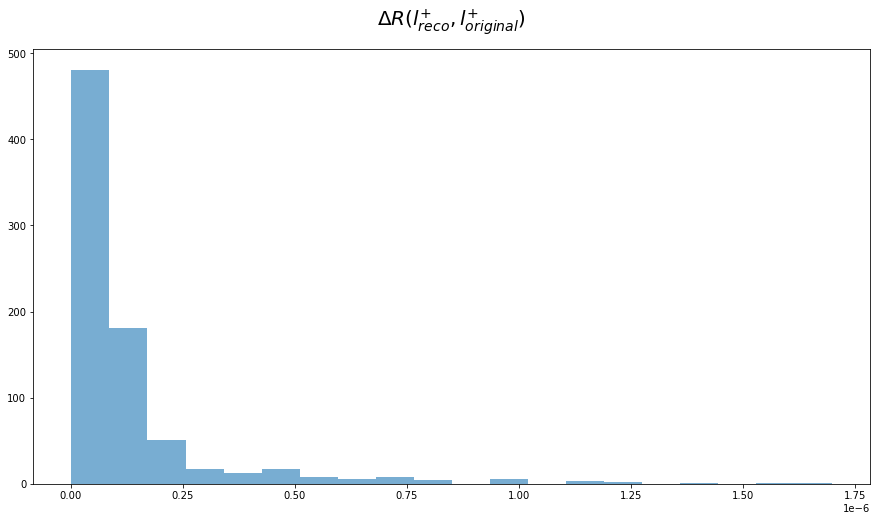

In [17]:
_ = histos.hist_var(dRs_l_t, label=r"$\Delta R(l^{+}_{reco}, l^{+}_{original})$")

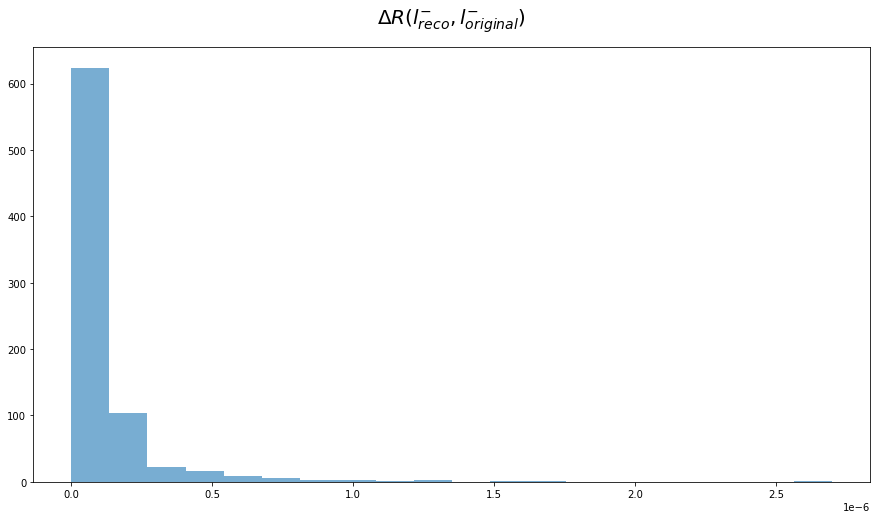

In [18]:
_ = histos.hist_var(dRs_l_tbar, label=r"$\Delta R(l^{-}_{reco}, l^{-}_{original})$")

### b-jets

In [19]:
dRs_b_t = list()
for idx in range(len(b_t_pre)):
    cand_dR = 1e10
    for jdx in range(len(b_t_pre[idx])):
        dR = kinematics.dR(b_t_pre[idx][jdx: jdx + 1], arrays["p_b_t"][idx: idx + 1])
        if dR < cand_dR:
            cand_dR = float(dR)
    if cand_dR != 1e10:
        dRs_b_t.append(cand_dR)
    
dRs_b_tbar = list()
for idx in range(len(b_tbar_pre)):
    cand_dR = 1e10
    for jdx in range(len(b_tbar_pre[idx])):
        dR = kinematics.dR(b_tbar_pre[idx][jdx: jdx + 1], arrays["p_b_tbar"][idx: idx + 1])
        if dR < cand_dR:
            cand_dR = float(dR)
    if cand_dR != 1e10:
        dRs_b_tbar.append(cand_dR)

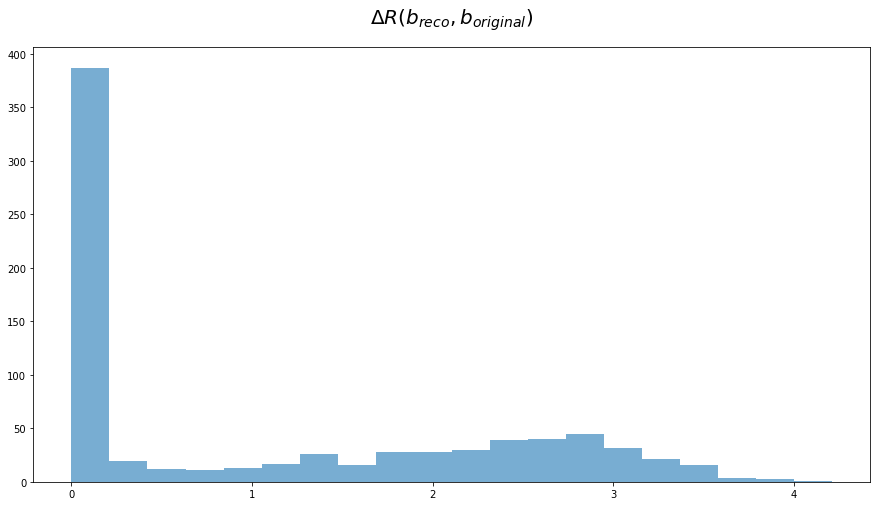

In [20]:
_ = histos.hist_var(dRs_b_t, label=r"$\Delta R(b_{reco}, b_{original})$")

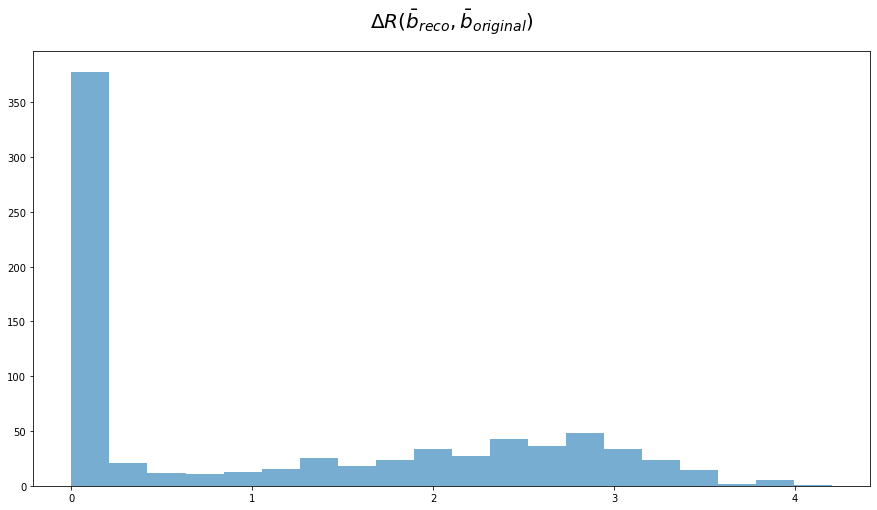

In [21]:
_ = histos.hist_var(dRs_b_tbar, label=r"$\Delta R(\bar{b}_{reco}, \bar{b}_{original})$")

### Neutrinos

In [22]:
dRs_nu_t = list()
for idx in range(len(nu_t_pre)):
    cand_dR = 1e10
    for jdx in range(len(nu_t_pre[idx])):
        dR = kinematics.dR(nu_t_pre[idx][jdx: jdx + 1], arrays["p_nu_t"][idx: idx + 1])
        if dR < cand_dR:
            cand_dR = float(dR)
    if cand_dR != 1e10:
        dRs_nu_t.append(cand_dR)
    
dRs_nu_tbar = list()
for idx in range(len(nu_tbar_pre)):
    cand_dR = 1e10
    for jdx in range(len(nu_tbar_pre[idx])):
        dR = kinematics.dR(nu_tbar_pre[idx][jdx: jdx + 1], arrays["p_nu_tbar"][idx: idx + 1])
        if dR < cand_dR:
            cand_dR = float(dR)
    if cand_dR != 1e10:
        dRs_nu_tbar.append(cand_dR)

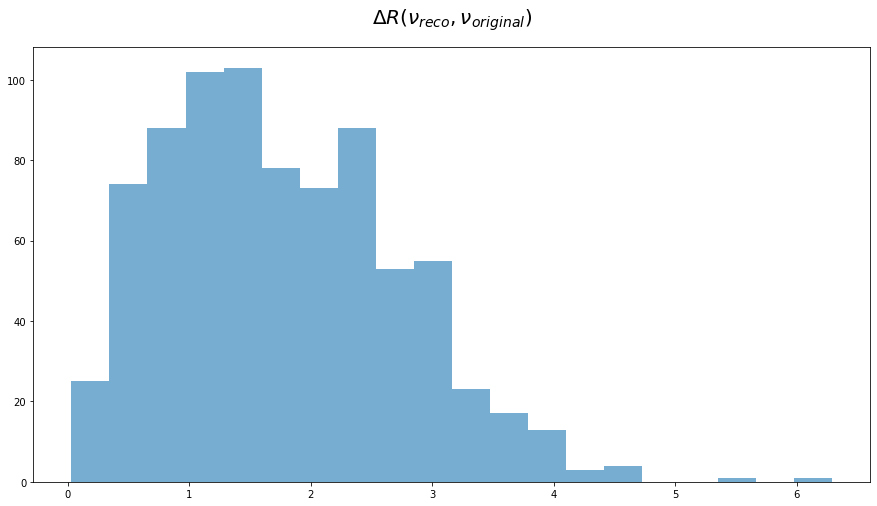

In [23]:
_ = histos.hist_var(dRs_nu_t, label=r"$\Delta R(\nu_{reco}, \nu_{original})$")

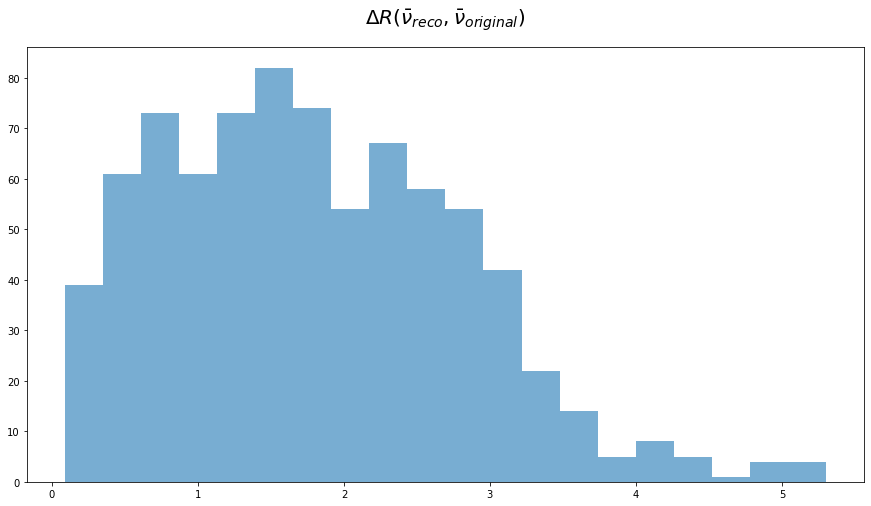

In [26]:
_ = histos.hist_var(dRs_nu_tbar, label=r"$\Delta R(\bar{\nu}_{reco}, \bar{\nu}_{original})$")

## Kinematics Comparison

../plotting/histos.py:140: UserWarning: The handle <BarContainer object of 20 artists> has a label of '_' which cannot be automatically added to the legend.
  ax[0].legend(legends)
../plotting/histos.py:150: RuntimeWarning: invalid value encountered in true_divide
  error_ratio = ratios * (ref_frac_error + p_errors[label]/p_bins[label])


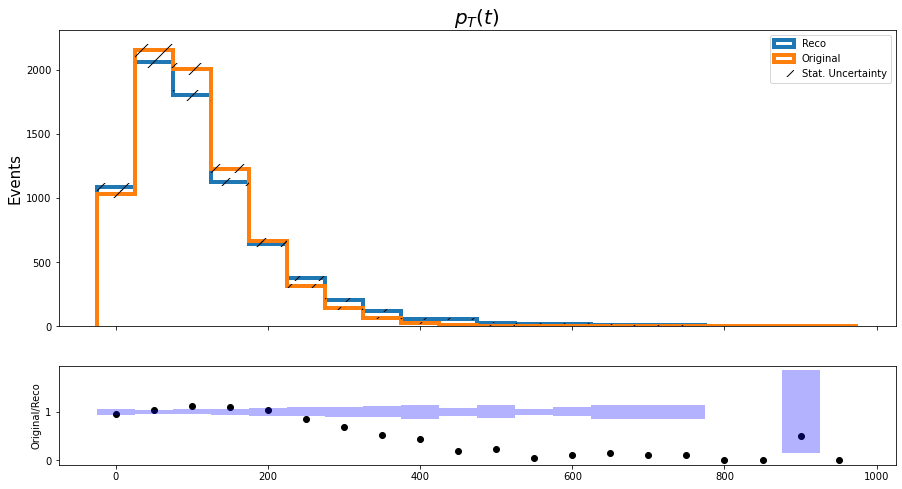

In [3]:
top_pt = np.sqrt(p_top[:, 0]**2 + p_top[:, 1]**2)
top_pre_pt = np.sqrt(p_top_pre[:, 0]**2 + p_top_pre[:, 1]**2)

histos.ratio_hist(
    processes_q=[top_pt, top_pre_pt],
    hist_labels=["Reco", "Original"],
    reference_label="Reco",
    n_bins=20,
    hist_range=(0, 1000),
    title=r"$p_T(t)$"
)